In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import numpy as np
from keras.callbacks import ModelCheckpoint

In [2]:
sdir = r'D:\ADSA\KULIAH\SEMESTER 4\KECERDASAN BUATAN\Project UAS\dataset'

filepaths = []
labels = []
classlist = os.listdir(sdir)
for klass in classlist:
    classpath = os.path.join(sdir, klass)
    if os.path.isdir(classpath):
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(klass)

Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)
print(df.head())
print(df['labels'].value_counts())


                                           filepaths  labels
0  D:\ADSA\KULIAH\SEMESTER 4\KECERDASAN BUATAN\Pr...  Anjing
1  D:\ADSA\KULIAH\SEMESTER 4\KECERDASAN BUATAN\Pr...  Anjing
2  D:\ADSA\KULIAH\SEMESTER 4\KECERDASAN BUATAN\Pr...  Anjing
3  D:\ADSA\KULIAH\SEMESTER 4\KECERDASAN BUATAN\Pr...  Anjing
4  D:\ADSA\KULIAH\SEMESTER 4\KECERDASAN BUATAN\Pr...  Anjing
labels
Anjing          170
Ayam            170
Bebek           170
Bintang Laut    170
Harimau         170
Hiu             170
Kucing          170
Kuda Laut       170
Nemo            170
Paus            170
Name: count, dtype: int64


In [3]:
train_split = .8
test_split = .1
dummy_split = test_split / (1 - train_split)
train_df, dummy_df = train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df = train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  1360   test_df length:  170   valid_df length:  170


In [4]:
height=256
width=256
channels=3
batch_size=64

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

gen=ImageDataGenerator(
    rescale=1./255,
    )
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

validgen=ImageDataGenerator(rescale=1./255)
valid_gen=validgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen=ImageDataGenerator(rescale=1./255)
test_gen=testgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)

test batch size:  34   test steps:  5
Found 1360 validated image filenames belonging to 10 classes.
Found 170 validated image filenames belonging to 10 classes.
Found 170 validated image filenames belonging to 10 classes.
['Anjing', 'Ayam', 'Bebek', 'Bintang Laut', 'Harimau', 'Hiu', 'Kucing', 'Kuda Laut', 'Nemo', 'Paus']


In [5]:
height = 256
width = 256
channels = 3
batch_size = 64

img_shape = (height, width, channels)
img_size = (height, width)
length = len(test_df)
test_batch_size = sorted([int(length / n) for n in range(1, length + 1) if length % n == 0 and length / n <= 80], reverse=True)[0]
test_steps = int(length / test_batch_size)
print('test batch size: ', test_batch_size, '  test steps: ', test_steps)


test batch size:  34   test steps:  5


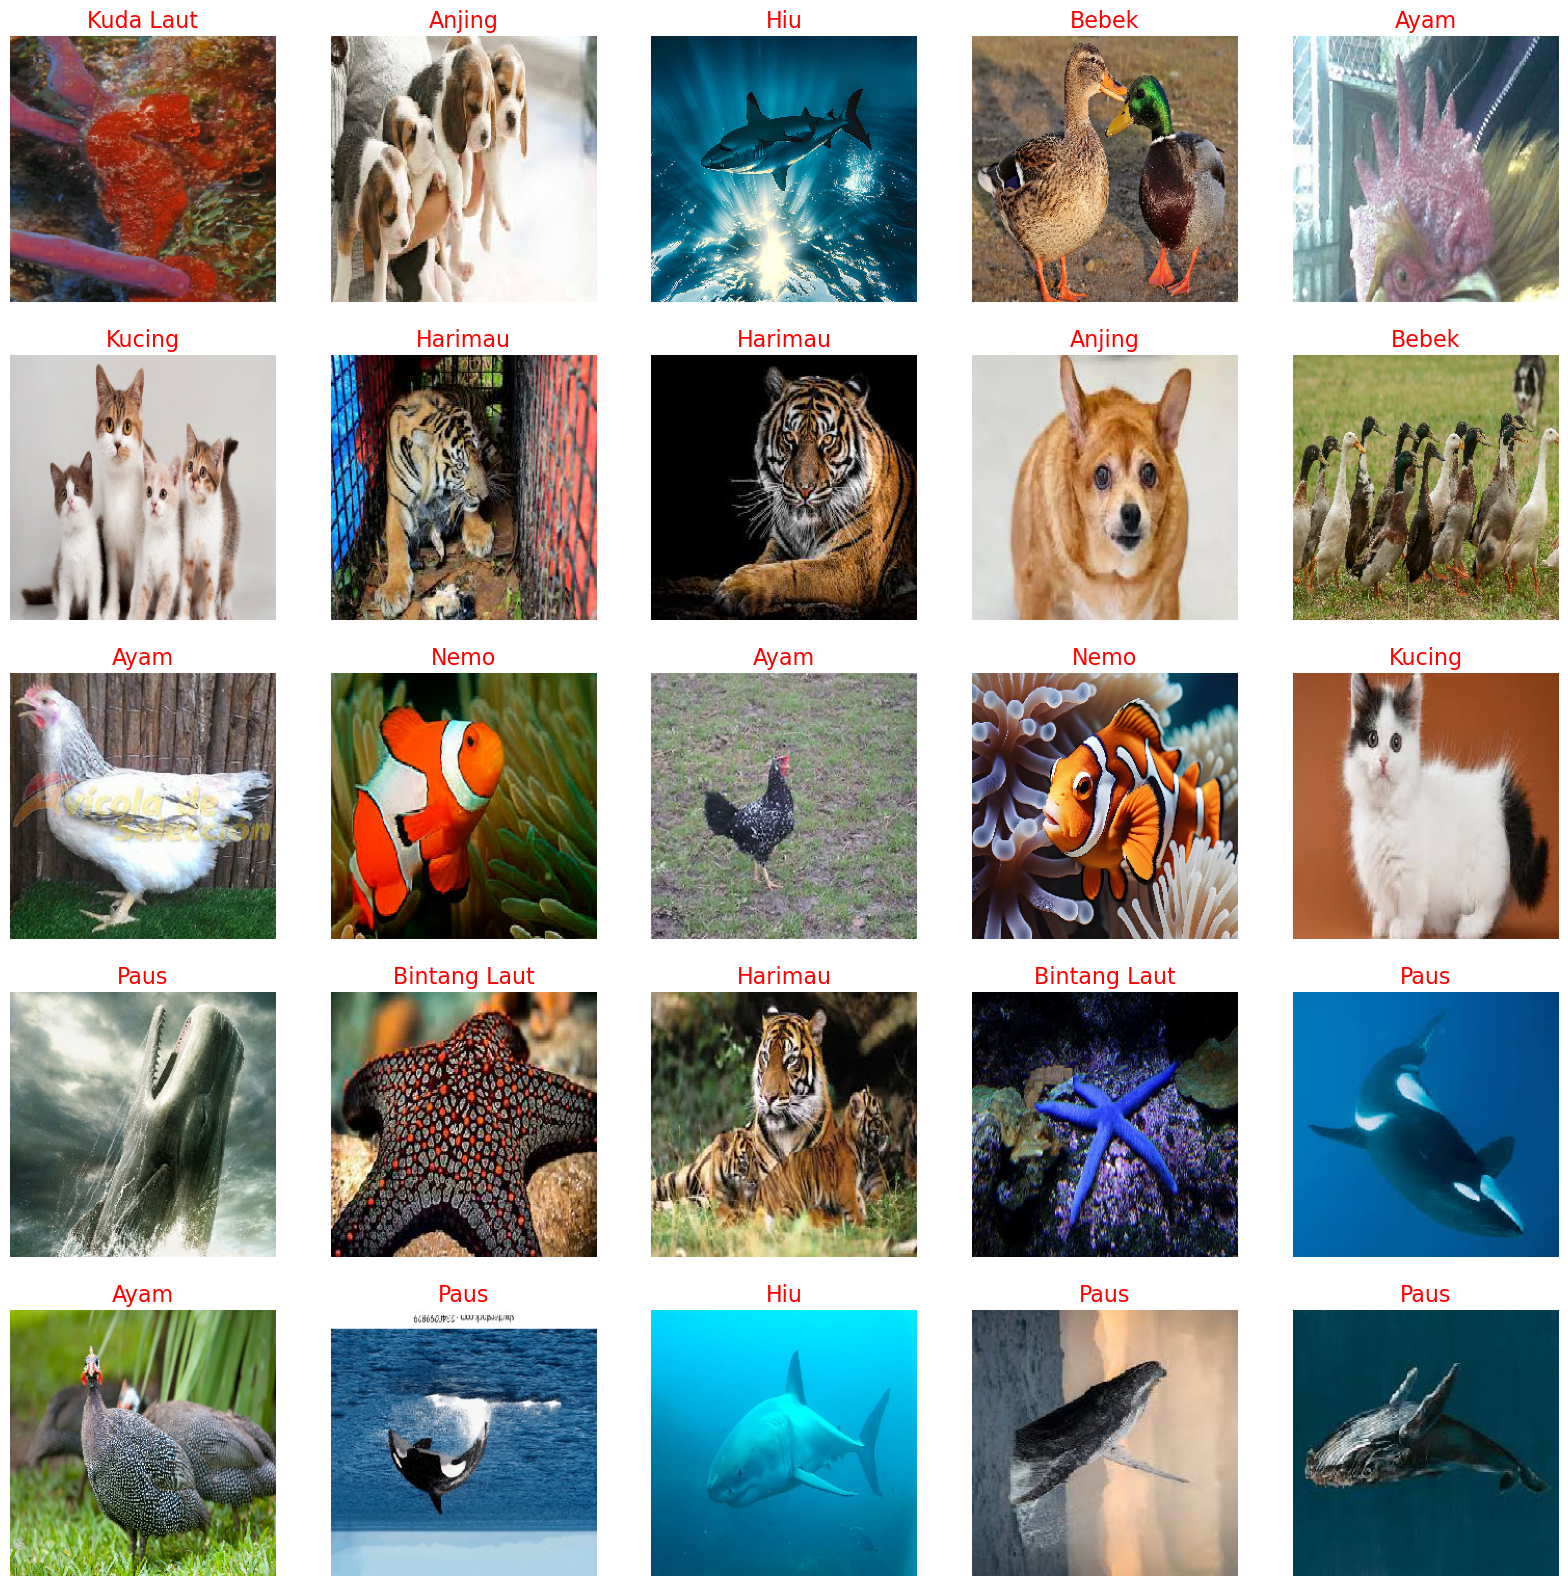

In [6]:
def show_image_samples(gen):
    test_dict = test_gen.class_indices
    classes = list(test_dict.keys())
    images, labels = next(gen)  # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length = len(labels)
    r = min(length, 25)  # show maximum of 25 images
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = images[i]
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='red', fontsize=16)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen)

In [7]:
base_model=tf.keras.applications.NASNetMobile(include_top=False, weights="imagenet",input_tensor=Input(shape=(256,256,3))) 
base_model.trainable = False

inputs = Input(shape=(256,256,3))
x = base_model(inputs, training=False)
x = Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1)(x)
x = MaxPooling2D(pool_size=2, strides=2)(x)
x = Dropout(rate=0.5)(x)
x = Flatten()(x)
outputs = Dense(class_count, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [8]:
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ nasnet_mobile (Functional)      │ (None, 8, 8, 1056)     │     4,269,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 8, 8, 32)       │       304,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,579,006 (17.47 MB)

 Trainable params: 309,290 (1.18 MB)

 Non-trainable params: 4,269,716 (16.29 MB)

In [9]:
epochs=50

mc = ModelCheckpoint('klasifikasi_hewan.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)  
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
history=model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen,callbacks=[early_stopping, mc])

Epoch 1/50


c:\Users\agusa\AppData\Local\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:21 5s/step - accuracy: 0.2254 - loss: 2.8507

c:\Users\agusa\AppData\Local\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4397 - loss: 1.9165
Epoch 1: val_accuracy improved from -inf to 0.93529, saving model to klasifikasi_hewan.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 336s 10s/step - accuracy: 0.4479 - loss: 1.8858 - val_accuracy: 0.9353 - val_loss: 0.2174
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8721 - loss: 0.3696
Epoch 2: val_accuracy improved from 0.93529 to 0.95882, saving model to klasifikasi_hewan.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 219s 9s/step - accuracy: 0.8733 - loss: 0.3673 - val_accuracy: 0.9588 - val_loss: 0.1254
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9507 - loss: 0.1805
Epoch 3: val_accuracy improved from 0.95882 to 0.96471, saving model to klasifikasi_hewan.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 211s 9s/step - accuracy: 0.9505 - loss: 0.1808 - val_accuracy: 0.9647 - val_loss: 0.0951
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9583 - loss: 0.1314
Epoch 4: val_accuracy improved from 0.96471 t

In [13]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [14]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

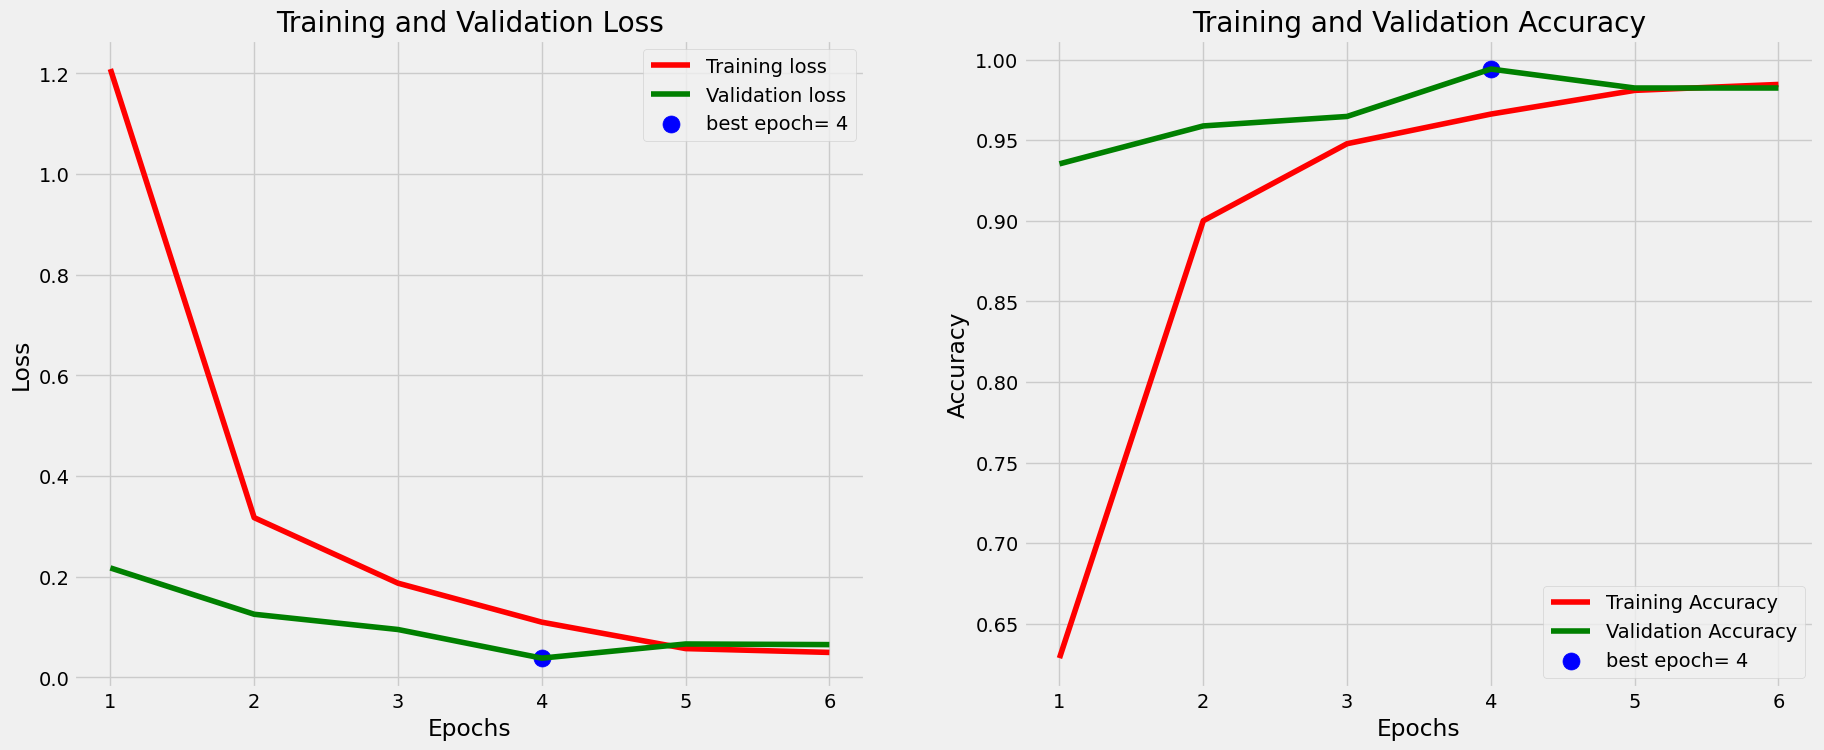

5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - accuracy: 0.9763 - loss: 0.1188
accuracy on the test set is 97.06 %



In [15]:
tr_plot(history,0)
save_dir=r'D:\ADSA\KULIAH\SEMESTER 4\KECERDASAN BUATAN\Project UAS'
subject='Klasifikasi Hewan'
model_name = 'Hewan Klasifikasi'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)